# Project Question

> Create a search function to search in a NAS space for the best performing **CNN architecture** on fashion-mnist.

Your task is to create a search function which searches for the model genome string that provides the best accuracy while using the least number of parameters.

Your program will return a model genome string (described below) which can be fed to a train function (provided below) to get the lowest parameter count and best accuracy after training.

**This is an open research problem**. You can use any method to search for the best genome and there might not be a perfect solution possible (prefect in the sense of maximum accuracy with minimum parameters). You will likely find tradeoffs between accuracy and number of parameters and you must balance such tradeoffs at your discretion.

> Aim for a search function that finds a genome with accuracy at least 75%.

You are encouraged to experiment with different techniques and apply your intuition to find a good search algorithm.

## CNN Architecture Constraints

Your search algorithm should search for models with the following basic structure.

Sequential model (no skip connections) having the following layers,
- Any number of normal(NC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A normal CNN layer has the following constraints,
    - `stride=1`
    - `padding=same`
    - `1 <= kernel size < 8`
    - Any of the following activation functions,
      - relu
      - sigmoid
      - tanh
      - swish
      - gelu
- **Exactly** 2 reduction(RC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A reduction layer has the **same** constraints as the normal layer except the following,
    - `stride=2`
    - `padding=valid`
- **Exactly** the following structure as the **final layers**,
  - First, a Global Average Pooling 2D layer.
    - `torch.nn.AvgPool2d(kernel_size=layer_input_image_size)` or `tf.keras.layers.GlobalAveragePooling2D`
  - Then, a Fully Connected/Dense layer with 64 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(64)` or `tf.keras.layers.Dense(64)`
  - Then, a Fully Connected/Dense layer with 10 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(10)` or `tf.keras.layers.Dense(10)`


The normal(NC) and reduction(RC) layers can be in **any order** as long as the constraints above are maintained.

The final layers of you model should be exactly as mentioned in these constraints.

All of the above contraints **apply only to your final output**. During searching for the best architecture you can do whatever you want.

Once your algorithm finds the best architecture, it should represent the architecture as a genome string (explained below) which will be fed to the training function given below to get the final accuracy.

In [ ]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

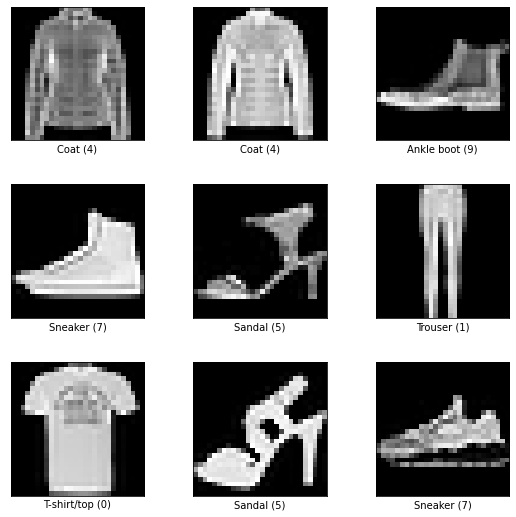

In [ ]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [ ]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "RC 32 3 tanh;RC 32 3 swish;FL swish;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 32)        320       
                                                                 
 Layer_1_RC (Conv2D)         (None, 6, 6, 32)          9248      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 12,330
Trainable params: 12,330
Non-trainable params: 0
____________________________________________________

In [ ]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None,epo: int=1):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=epo,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

In [ ]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

name 'train_model' is not defined

Your input genome: NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;


In [ ]:
#@title Deep model genome example
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;
Model params: 607946
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 64)        128       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 64)        4160      
                                                                 
 Layer_3_RC (Conv2D)         (None, 13, 13, 128)       73856     
                                                                 
 Layer_4_NC (Conv2D)         (None, 13, 13, 128)       16512     
                                                                 
 Layer_5_NC (Conv2D)         (

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8097000122070312
Return value: (0.8097000122070312, 0.6823999881744385, 607946)


## Hints

- Consider caching genome results for faster querying.
  - This has a risk. The training process itself is non-deterministic and thus training the same genome multiple times can sometimes give drastically different results. Generally such difference in accuracy of the same genome is small but sometimes it be upto 30%.
- Consider saving your search algorithm state such that it can resume from a previous search point if it gets interrupted due to a crash or colab time restrictions.
  - Google colab is free and hence it has time limits on how long you can use the GPU. If you implement checkpointing in your code such that it saves checkpoints on your GDrive, you can save a lot of time when such interruptions happen.
  - You can mount your GDrive to colab and save/load files from your drive folders.
- Don't forget to enable GPU in colab.
  - https://colab.research.google.com/notebooks/gpu.ipynb
- If colab shows errors in code that was working before try to do `Runtime->Restart Runtime`. This is especially true if you stopped execution while a model was being trained.
  - You can also try `Runtime->Factory Reset Runtime` to get a clean slate (revert installed libraries to colab defaults).

# Answer
Write your answer and its code under this section.

In [ ]:
import math
import random

In [ ]:
# -----------------------
def cost(acc_and_param):
  acc=0.8*acc_and_param[0]+0.2*acc_and_param[1]
  w_acc=(1-8/15*acc)
  w_param=1-w_acc
  cost_v=w_acc*acc + w_param*(10000.0/acc_and_param[2])
  return cost_v

In [ ]:
# ---------------
def convert_gnome(model_list):
  genome_str = ''
  act_dict = {0:'relu', 1:'sigmoid', 2:'tanh', 3:'swish', 4:'gelu'}
  for l in model_list[:-1]:
    if len(l) == 4 and l[0] == 1:
      genome_str += 'NC '+ str(l[1]) + ' ' + str(l[2]) + ' ' + act_dict[l[-1]] + ';'
    else:
      genome_str += 'RC '+ str(l[1]) + ' ' + str(l[2]) + ' ' + act_dict[l[-1]] + ';'
  genome_str += 'FL ' + act_dict[model_list[-1][-1]] + ';'
  return genome_str

In [ ]:
# ------------------------------

def select_best_candidate(selection_percentage,current_population,acc_and_param):
  size=math.floor(selection_percentage*len(current_population))
  list2=[]
  for x in range(len(current_population)):
    listn=[]
    listn.append(current_population[x])
    listn.append(x)
    listn.append(cost(acc_and_param[x]))
    list2.append(listn)
  list4=sorted(list2,key=lambda x:x[2],reverse=True)[:size]
  new_list=[item[0] for item in list2 if item not in list4]
  best_cand=[item[0] for item in list4]
  current_population=list(new_list)
  return best_cand,new_list
  
  

In [ ]:
# -------------
def select_randomly(current_population,size):
  random_cand=random.sample(current_population,size)
  return random_cand

In [ ]:
# ----------------------
def mate_candidate(new_population,recombination_rate):
  size=len(new_population)
  # 
  size=math.floor(size)
  x=math.floor(random.randint(2,size)*recombination_rate)
  size=math.floor(size/2)
  child=[]
  # for 
  for i in range(x):
    z=random.randint(0,size)
    k=random.randint(size+1,len(new_population)-1)
    sizeone=len(new_population[z])
    sizetwo=len(new_population[k])
    # l=random.randint(0,sizeone-1)
    # m=random.randint(0,sizetwo-1)
    mi=min(sizeone,sizetwo)
    x=l=random.randint(0,mi)
    l=random.sample(range(0,sizeone),x)
    m=random.sample(range(0,sizetwo),x)
    ch1=list(new_population[z])
    ch2=list(new_population[k])
    for c in range(x):
      if ch1[l[c]][0]==ch2[m[c]][0]:
        temp=ch1[l[c]]
        ch1[l[c]]=ch2[m[c]]
        ch2[m[c]]=temp
    child.append(ch1)
    child.append(ch2)
  

  return child
    




In [ ]:
# ashish----------------
def mutate_candidate(new_population,mutation_rate):
  num = int(mutation_rate*len(new_population))
  to_mutate = random.sample(new_population, num)
  mutated = []
  for cand in to_mutate:
    chos = random.randint(0, len(cand)- 2)
    pos = random.randint(1,3)
    if pos == 1:
      new = random.randint(32, 256)
      cand[chos][pos] = new
      mutated.append(cand)
    elif pos == 2:
      new = random.randint(1,7)
      if new%2 == 0: new += 1
      cand[chos][pos] = new
      mutated.append(cand)
    elif pos == 3:
      new = random.randint(0,4)
      cand[chos][pos] = new
      mutated.append(cand)
  return mutated

In [ ]:
#----------------------
def find_best_performing_gnome(current_population,acc_and_param):
  max=0
  for i in range(len(acc_and_param)):
    if cost(acc_and_param[i])>cost(acc_and_param[max]):
      max=i
  return current_population[max],acc_and_param[max]
  


relu----0
sigmoid----1
tanh----2
swish-----3
gelu-----4

In [ ]:
# initialize_population:-------------------------------- 
import random

def initialize_population(population_size):
  # rand=[[0,8,3,0],[0,6,4,1],[2,1]]
  population=[]
  # population.append(rand)
  for i in range(population_size):
    x=random.randint(0,4)
    gn_string=[]
    for j in range(x):
      layer=[]
      layer.append(1)
      y=random.randint(32,128)
      layer.append(y)
      y=random.randint(1,7)
      layer.append(y)
      y=random.randint(0,4)
      layer.append(y)
      gn_string.append(layer)
    rc_layer=[]
    rc_layer.append(0)
    z=random.randint(32,128)
    rc_layer.append(z)
    z=random.randint(1,7)
    rc_layer.append(z)
    z=random.randint(0,4)
    rc_layer.append(z)
    gn_string.append(rc_layer)
    x=random.randint(0,4)
    for j in range(x):
      layer=[]
      layer.append(1)
      y=random.randint(32,128)
      layer.append(y)
      y=random.randint(1,7)
      layer.append(y)
      y=random.randint(0,4)
      layer.append(y)
      gn_string.append(layer)
    rc_layer=[]
    rc_layer.append(0)
    z=random.randint(32,128)
    rc_layer.append(z)
    z=random.randint(1,7)
    rc_layer.append(z)
    z=random.randint(0,4)
    rc_layer.append(z)
    gn_string.append(rc_layer)
    z=random.randint(0,4)
    gn_string.append([2,z])
    population.append(gn_string)
  print(population)
  return population




In [ ]:
# Main_algo--------------------------------------------------------

def Evolutionary_algo(no_of_iterations=3,population_size=5,recombination_rate=0.3,mutation_rate=0.3,selection_percentage=0.4):
  current_population=initialize_population(population_size)
  for i in range(no_of_iterations):
    acc_and_param=[]
    for i in range(len(current_population)):
      gnome=convert_gnome(current_population[i])    
      test_acc,train_acc,n_para=train_model(gnome, 1,  1e-3, 0.1,epo=1)
      acc_and_param.append([test_acc,train_acc,n_para])
    best_candidates,current_population2=select_best_candidate(selection_percentage,current_population,acc_and_param)
    current_population_size=len(current_population2) 
    size=math.floor(current_population_size*(1-selection_percentage))
    random_candidates=select_randomly(current_population2,size)
    new_population=[]
    for x in best_candidates:
      new_population.append(x)
    for x in random_candidates:
      new_population.append(x)
    child_candidate=mate_candidate(new_population,recombination_rate)
    mutated_canditate=mutate_candidate(new_population,mutation_rate)
    for x in child_candidate:
      new_population.append(x)
    for x in mutated_canditate:
      new_population.append(x)
    current_population=new_population
    # with open()-------------------------------------------

    # ------------------------------------------------------------------------------------------------------

  acc_and_param=[]  
  for i in range(population_size):
    gnome=convert_gnome(current_population[i])
    test_acc,train_acc,n_para=train_model(gnome, 1,  1e-3,  0.1, epo=1)
    acc_and_param.append([test_acc,train_acc,n_para])
  best_can,acc=find_best_performing_gnome(current_population,acc_and_param)
  best_gnome=convert_gnome(best_can)
  print("best model","::::",best_gnome)
  print("with accuracy","::::",acc[0])
  return best_gnome,acc,current_population,acc_and_param


In [ ]:
best_model,acc,pop,accp=Evolutionary_algo(5,8,0.6,0.6,0.4)


[[[0, 125, 7, 2], [1, 83, 5, 4], [1, 39, 2, 1], [0, 112, 4, 4], [2, 1]], [[0, 39, 6, 4], [1, 111, 6, 3], [1, 55, 2, 1], [0, 80, 4, 4], [2, 1]], [[1, 87, 3, 4], [1, 56, 3, 2], [0, 79, 3, 4], [1, 48, 7, 3], [1, 108, 7, 1], [1, 103, 2, 4], [1, 33, 5, 4], [0, 107, 2, 0], [2, 0]], [[1, 82, 6, 2], [0, 90, 4, 3], [0, 65, 7, 4], [2, 2]], [[1, 95, 1, 4], [1, 95, 5, 4], [1, 94, 7, 3], [0, 39, 1, 1], [1, 117, 4, 0], [1, 117, 5, 3], [0, 116, 1, 0], [2, 0]], [[0, 73, 4, 4], [1, 113, 7, 3], [1, 123, 5, 1], [1, 118, 1, 4], [1, 58, 2, 2], [0, 49, 4, 0], [2, 2]], [[1, 112, 4, 3], [0, 68, 7, 0], [1, 51, 3, 4], [1, 34, 5, 3], [0, 61, 7, 2], [2, 2]], [[0, 125, 7, 1], [0, 74, 6, 0], [2, 4]]]
Training genome: RC 125 7 tanh;NC 83 5 gelu;NC 39 2 sigmoid;RC 112 4 gelu;FL sigmoid;
Model params: 356577


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Best test accuracy: 0.7391999959945679
Training genome: RC 39 6 gelu;NC 111 6 swish;NC 55 2 sigmoid;RC 80 4 gelu;FL sigmoid;
Model params: 258187


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7077999711036682
Training genome: NC 87 3 gelu;NC 56 3 tanh;RC 79 3 gelu;NC 48 7 swish;NC 108 7 sigmoid;NC 103 2 gelu;NC 33 5 gelu;RC 107 2 relu;FL relu;
Model params: 676049


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 82 6 tanh;RC 90 4 swish;RC 65 7 gelu;FL tanh;
Model params: 412793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8080000281333923
Training genome: NC 95 1 gelu;NC 95 5 gelu;NC 94 7 swish;RC 39 1 sigmoid;NC 117 4 relu;NC 117 5 swish;RC 116 1 relu;FL relu;
Model params: 1104572


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.4661000072956085
Training genome: RC 73 4 gelu;NC 113 7 swish;NC 123 5 sigmoid;NC 118 1 gelu;NC 58 2 tanh;RC 49 4 relu;FL tanh;
Model params: 844590


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7049999833106995
Training genome: NC 112 4 swish;RC 68 7 relu;NC 51 3 gelu;NC 34 5 swish;RC 61 7 tanh;FL tanh;
Model params: 556108


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7865999937057495
Training genome: RC 125 7 sigmoid;RC 74 6 relu;FL gelu;
Model params: 344774


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.22380000352859497
Training genome: NC 82 6 sigmoid;RC 90 4 swish;RC 65 7 gelu;FL tanh;
Model params: 412793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6477000117301941
Training genome: NC 112 4 swish;RC 68 7 relu;NC 51 3 gelu;NC 34 5 swish;RC 61 7 tanh;FL tanh;
Model params: 556108


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8080000281333923
Training genome: RC 125 7 tanh;NC 83 5 gelu;NC 39 2 sigmoid;RC 112 4 gelu;FL sigmoid;
Model params: 356577


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7182999849319458
Training genome: RC 125 7 sigmoid;RC 74 6 relu;FL gelu;
Model params: 344774


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.04320000112056732
Training genome: RC 39 6 gelu;NC 111 6 swish;NC 55 2 sigmoid;RC 80 4 gelu;FL sigmoid;
Model params: 258187


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7161999940872192
Training genome: NC 87 3 gelu;NC 56 3 tanh;RC 79 3 gelu;NC 48 7 swish;NC 108 7 sigmoid;NC 103 2 gelu;NC 33 5 gelu;RC 107 2 relu;FL relu;
Model params: 676049


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 112 4 swish;RC 68 7 relu;NC 51 3 gelu;NC 56 3 tanh;RC 61 7 tanh;FL tanh;
Model params: 604242


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7856000065803528
Training genome: NC 87 3 gelu;NC 34 5 swish;RC 79 3 gelu;NC 48 7 swish;NC 108 7 sigmoid;NC 103 2 gelu;NC 33 5 gelu;RC 107 2 relu;FL relu;
Model params: 690487


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6758000254631042
Training genome: NC 87 3 gelu;NC 56 3 tanh;RC 79 3 gelu;NC 48 7 swish;NC 108 7 sigmoid;NC 103 2 gelu;NC 33 5 gelu;RC 107 2 relu;FL relu;
Model params: 676049


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 82 6 sigmoid;RC 90 4 swish;RC 65 7 gelu;FL tanh;
Model params: 412793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7063999772071838
Training genome: NC 112 4 swish;RC 68 7 relu;NC 51 3 gelu;NC 34 5 swish;RC 61 7 tanh;FL tanh;
Model params: 556108


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7950000166893005
Training genome: NC 112 4 swish;RC 68 1 relu;NC 51 3 gelu;NC 34 5 swish;RC 61 7 relu;FL tanh;
Model params: 190540


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7610999941825867
Training genome: NC 112 4 swish;RC 68 1 relu;NC 51 3 gelu;NC 34 5 swish;RC 61 7 relu;FL tanh;
Model params: 190540


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.746999979019165
Training genome: NC 112 4 swish;RC 68 1 relu;NC 51 3 gelu;NC 56 3 tanh;RC 61 7 relu;FL tanh;
Model params: 238674


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

In [ ]:
print("best model","::::",best_model)
print("with test accuracy","::::",acc[0])
print("train accuracy",":::",acc[1])
print("parameters",":::::",acc[2])

best model :::: NC 40 7 swish;NC 113 6 tanh;NC 113 6 tanh;RC 121 5 tanh;NC 126 1 relu;NC 62 7 sigmoid;NC 110 4 tanh;RC 53 2 tanh;FL swish;
with test accuracy :::: 0.8824999928474426
train accuracy ::: 0.8858000040054321
parameters ::::: 1501507
